In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"





In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )

print("\n\n")




  numpy version:  1.26.4





## Set model and resolution parameters

In [3]:
ndim = 1

##-------------

train_mu = [ 0.0 ]



train_rho = [ [0.0] ]






train_sig = [ 1.0 ]


##-------------


true_mu = [ 0.2 ]






true_rho  = [ [0.0] ]



true_sig = [ 0.9 ]






#--- perfect
resolution = [ 0.000001  ]

#--- very good
#resolution = [ 0.05  ]

#--- good
#resolution = [ 0.25  ]

#--- nominal
#resolution = [ 0.5  ]

#--- medium poor
#resolution = [ 0.75  ]

#--- poor
#resolution = [ 1.0  ]







train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                






ngen_train = 100000
ngen_true =   10000

#ngen_train = 1000000
#ngen_true =   100000

of_niter = 5


use_poisson_fluctuations_around_ngen_true = True


do_bootstrap = False

n_boot_samples = 500



ds_input_dir = 'toy-study6b-1d-1a-10k'


output_dir = 'hist-pdf-toy-study-1d-3a'

#save_step2_model = True



hist_low = -10.
hist_high = 10.

hist_nbins = 1000


hist_binwidth = (hist_high - hist_low) / hist_nbins

window_dx = 0.3

window_nbins = int( window_dx / hist_binwidth )

print(' window_nbins : %d' % window_nbins)

hist_pars = {}
hist_pars['low']  = hist_low
hist_pars['high'] = hist_high
hist_pars['nbins'] = hist_nbins
hist_pars['binwidth'] = hist_binwidth
hist_pars['window_dx'] = window_dx
hist_pars['window_nbins'] = window_nbins






 Train covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100
 window_nbins : 15


In [4]:
hist_pars

{'low': -10.0,
 'high': 10.0,
 'nbins': 1000,
 'binwidth': 0.02,
 'window_dx': 0.3,
 'window_nbins': 15}

In [5]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()



 Output directory already exists:  hist-pdf-toy-study-1d-3a


In [6]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.000000
True covariance determinant:   0.810000





In [7]:
train_cov_inv = np.linalg.inv( train_cov )

In [8]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [9]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[1.]]

 Train covariance inverse
[[1.]]

 Train covariance inverse test
[[1.]]





In [10]:
true_cov_inv = np.linalg.inv( true_cov )

In [11]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [12]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [13]:

#--- Read the datasets instead of generating new ones.

train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)


this_ngen_true = ngen_true
if use_poisson_fluctuations_around_ngen_true : this_ngen_true = np.random.poisson( ngen_true )

true_pts = np.random.multivariate_normal(true_mu, true_cov, size=this_ngen_true)




train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )



#with open('%s/train-and-true-samples.npy' % ds_input_dir, 'rb') as f :
#    train_pts = np.load(f)
#    train_det_pts = np.load(f)
#    true_pts = np.load(f)
#    true_det_pts = np.load(f)

print('\n\n train_pts:')
print( train_pts )
print('\n\n')
print(' train_pts shape:  %s' % str(train_pts.shape))

train_both = np.stack([train_pts, train_det_pts], axis=1)
    
#-- ok to regenerate these (just for plots)
true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=this_ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( this_ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights




 train_pts:
[[-1.14045859]
 [-0.19938204]
 [-0.61329399]
 ...
 [ 1.89610969]
 [ 0.17192087]
 [-0.13173877]]



 train_pts shape:  (100000, 1)


In [14]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [15]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [16]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('use_poisson_fluctuations_around_total : %s\n' % str(use_poisson_fluctuations_around_ngen_true) )




config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : hist-pdf-toy-study-1d-3a/config.txt

2024-08-07 17:12:30.322124

ngen_train 100000
ngen_true  10000
of_niter   5
ndim       1
use_poisson_fluctuations_around_ngen_true : True


train_mu : [0.0]
train_rho : [[0.0]]
train_sig : [1.0]
train_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution : [1e-06]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

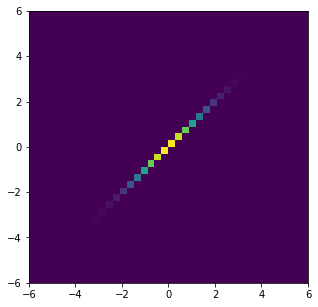

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

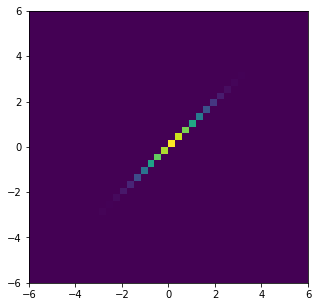

In [18]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

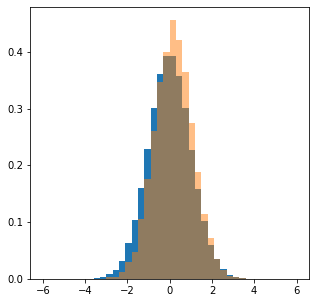

In [19]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [20]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[-1.14045859]
 [-0.19938204]
 [-0.61329399]
 ...
 [ 1.89610969]
 [ 0.17192087]
 [-0.13173877]]


In [21]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[-1.34045859]
 [-0.39938204]
 [-0.81329399]
 ...
 [ 1.69610969]
 [-0.02807913]
 [-0.33173877]]


In [22]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [23]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [24]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [25]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [26]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [27]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [28]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 2.544690



In [29]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 3.141593



In [30]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.2944377  0.55308613 0.46746551 ... 0.09348251 0.55591308 0.55931498]


In [31]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.20676792 0.56809596 0.41673485 ... 0.10616089 0.62657229 0.58570625]


In [32]:
pdf_ratio = pdf_true / pdf_train

In [33]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100510


In [34]:
calc_weight = pdf_ratio

In [35]:
calc_weight_scaled = sample_sf * pdf_ratio

In [36]:
with open( '%s/analytic-weights.npy' % output_dir, 'wb') as f :
    np.save(f, calc_weight_scaled)

## Define function for calculating model pars (mean and cov) from weighted events

In [37]:
def calc_mean_cov( weights, fi1, fi2, sample_points ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * sample_points[:,fi1] )
    wx2 = np.sum( weights * sample_points[:,fi2] )
    wx1x2 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi1] )
        wx2x2 = np.sum( weights * sample_points[:,fi2] * sample_points[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [38]:
weights_true = np.ones( this_ngen_true )

In [39]:
true_calc_mean = np.zeros( ndim )
true_calc_cov = np.ones( shape=(ndim,ndim) )

In [40]:
for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        rd = calc_mean_cov( weights_true, fi1, fi2, true_pts )
        true_calc_mean[fi1] = rd['mean_x1']
        true_calc_cov[fi1,fi2] = rd['cov_x1x2']

In [41]:
for fi1 in range(ndim) :
    print('  mean f%d :  %7.3f' % (fi1, true_calc_mean[fi1]))
    for fi2 in range(fi1,ndim) :
        print('  cov f%df%d :  %7.4f' % (fi1,fi2, true_calc_cov[fi1,fi2]))
        if fi1 == fi2 :
            print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(true_calc_cov[fi1,fi1])))
        

  mean f0 :    0.190
  cov f0f0 :   0.8180
  sigma f0 :   0.9045


In [42]:
print( true_pts.shape )
print( true_pts.shape[1])

(10051, 1)
1


In [43]:
def calc_model_pars( weights, sample_points, verbose=0 ) :
    
    return_dict = {}
    
    ndim = sample_points.shape[1]
    if verbose : print(' ndim = %d' % ndim )
    
    model_mean = np.zeros( ndim )
    model_cov = np.ones( shape=(ndim,ndim) )
    
    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            rd = calc_mean_cov( weights, fi1, fi2, sample_points )
            model_mean[fi1] = rd['mean_x1']
            model_cov[fi1,fi2] = rd['cov_x1x2']    
            if verbose and fi2==fi1 : print('  mean f%d :  %7.3f' % (fi1, model_mean[fi1]))
            if verbose : print('  cov f%df%d :  %7.4f' % (fi1,fi2, model_cov[fi1,fi2]))
            if verbose and fi2==fi1 : print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(model_cov[fi1,fi1])))
   
    for fi2 in range(ndim) :
        for fi1 in range(fi2+1,ndim) :
            model_cov[fi1,fi2] = model_cov[fi2,fi1]
    
    return_dict['mean'] = model_mean
    return_dict['cov']  = model_cov
    
    return return_dict


In [44]:
test_calc_true_model = calc_model_pars( weights_true, true_pts, 1)

 ndim = 1
  mean f0 :    0.190
  cov f0f0 :   0.8180
  sigma f0 :   0.9045


In [45]:
test_calc_true_model

{'mean': array([0.19030211]), 'cov': array([[0.81803756]])}

## Define function to calculate the reweighting factor (pdf2/pdf1).

In [46]:
def calc_pdf_ratio( model1_mu, model2_mu, model1_cov, model2_cov, sample_points ) :
    
    ndim = len(model1_mu)
    
    pts_minus_mu1 = sample_points - model1_mu
    pts_minus_mu2 = sample_points - model2_mu
    
    cov1_inv = np.linalg.inv( model1_cov )
    cov2_inv = np.linalg.inv( model2_cov )
    
    cov1_det = np.linalg.det( model1_cov )
    cov2_det = np.linalg.det( model2_cov )
    
    cov1_inv_times_v1 = np.tensordot( cov1_inv, pts_minus_mu1.T, axes=(1,0) )
    cov2_inv_times_v2 = np.tensordot( cov2_inv, pts_minus_mu2.T, axes=(1,0) )
    
    v1_times_cov1_inv_times_v1 =  np.sum( pts_minus_mu1.T * cov1_inv_times_v1, axis=0)
    v2_times_cov2_inv_times_v2 =  np.sum( pts_minus_mu2.T * cov2_inv_times_v2, axis=0)
    
    exp_v1_times_cov1_inv_times_v1 = np.exp( -0.5 * v1_times_cov1_inv_times_v1 )
    exp_v2_times_cov2_inv_times_v2 = np.exp( -0.5 * v2_times_cov2_inv_times_v2 )
    
    norm2_model1 = np.power( 3.14159265, ndim) * cov1_det
    norm2_model2 = np.power( 3.14159265, ndim) * cov2_det
    
    pdf1 = exp_v1_times_cov1_inv_times_v1 / np.sqrt(norm2_model1)
    pdf2 = exp_v2_times_cov2_inv_times_v2 / np.sqrt(norm2_model2)
    
    pdf_ratio = pdf1 / pdf2
    
    return pdf_ratio
    
    

In [47]:
test_calc_pdf_ratio = calc_pdf_ratio( true_mu, train_mu, true_cov, train_cov, train_pts )

In [48]:
test_calc_pdf_ratio

array([0.70224676, 1.02713833, 0.8914772 , ..., 1.13562298, 1.1271048 ,
       1.04718498])

In [49]:
pdf_ratio

array([0.70224676, 1.02713833, 0.8914772 , ..., 1.13562298, 1.1271048 ,
       1.04718498])

## Function that estimates the pdf from a histogram (multi-bin sum)

In [50]:

#-- computes pdf2/pdf1 at location of points1
#
#    for OmniFold step 1, points2 is the data, points1 is the MC
#

def pdf_ratio_from_hist( points1, points2, weights1, weights2, hist_pars, verbose=0 ) :
    
    ndim = points1.shape[1]
    
    if ndim > 1 :
        print('\n\n *** Only 1D supported for now.\n\n')
        sys.exit()
        
    hist_low = hist_pars['low']
    hist_high = hist_pars['high']
    hist_nbins = hist_pars['nbins']
    hist_binwidth = hist_pars['binwidth']
    
    
    nph1 = np.histogram( points1[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights1 )
    nph2 = np.histogram( points2[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights2 )
    
    hist_pdf1 = np.zeros(hist_nbins)
    hist_pdf2 = np.zeros(hist_nbins)

    for bi in range( hist_nbins ) :
        bilow = bi - window_nbins
        bihigh = bi + window_nbins
        if bilow < 0 : bilow = 0
        if bihigh >= hist_nbins : bihigh = hist_nbins-1

        hist_pdf1[bi] = np.sum( nph1[0][bilow: bihigh] )
        hist_pdf2[bi] = np.sum( nph2[0][bilow: bihigh] )
    
    hist_pdf1_norm = hist_pdf1 / np.sum(hist_pdf1)
    hist_pdf2_norm = hist_pdf2 / np.sum(hist_pdf2)
    
    hist_bin_indices1 = np.array(   ( (points1[:,0] - hist_low) / hist_binwidth ),   dtype=int )
    
    points1_pdf1_val = hist_pdf1_norm[ hist_bin_indices1 ]
    points1_pdf2_val = hist_pdf2_norm[ hist_bin_indices1 ]
    
    points1_pdf1_val = np.clip( points1_pdf1_val, 1.e-10, 1.e10)
    points1_pdf2_val = np.clip( points1_pdf2_val, 1.e-10, 1.e10)
    
    pdf_ratio = points1_pdf2_val / points1_pdf1_val
    
    return pdf_ratio
    

In [51]:
print('pdf_ratio shape : %s' % str(pdf_ratio.shape))

pdf_ratio shape : (100000,)


In [52]:
weights_true = np.ones( this_ngen_true )
weights_train = np.ones( ngen_train )

print(' train_pts shape: %s' % str(train_pts.shape))
print('  true_pts shape: %s' % str(true_pts.shape))
print(' weights_train shape: %s' % str(weights_train.shape))
print('  weights_true shape: %s' % str(weights_true.shape))

test_hist_pdf_ratio = pdf_ratio_from_hist( train_pts, true_pts, weights_train, weights_true, hist_pars )

 train_pts shape: (100000, 1)
  true_pts shape: (10051, 1)
 weights_train shape: (100000,)
  weights_true shape: (10051,)


In [53]:
pdf_ratio

array([0.70224676, 1.02713833, 0.8914772 , ..., 1.13562298, 1.1271048 ,
       1.04718498])

In [54]:
calc_weight

array([0.70224676, 1.02713833, 0.8914772 , ..., 1.13562298, 1.1271048 ,
       1.04718498])

In [55]:
test_hist_pdf_ratio

array([0.72512654, 1.01750845, 0.90327727, ..., 1.12901041, 1.13709477,
       1.03565334])

In [56]:
test_hist_pdf_ratio.shape

(100000,)

In [57]:
for pi in range(40) :
    print( ' %3d   x %7.3f   true  %7.4f  from hist %7.4f' % (pi, train_pts[pi,0], calc_weight[pi], test_hist_pdf_ratio[pi]))

   0   x  -1.140   true   0.7022  from hist  0.7251
   1   x  -0.199   true   1.0271  from hist  1.0175
   2   x  -0.613   true   0.8915  from hist  0.9033
   3   x  -0.736   true   0.8482  from hist  0.8660
   4   x   0.249   true   1.1443  from hist  1.1541
   5   x  -2.371   true   0.3123  from hist  0.3340
   6   x   0.235   true   1.1413  from hist  1.1518
   7   x   1.103   true   1.2341  from hist  1.1788
   8   x  -1.474   true   0.5838  from hist  0.5913
   9   x   0.462   true   1.1850  from hist  1.1995
  10   x  -1.534   true   0.5632  from hist  0.5714
  11   x  -0.708   true   0.8583  from hist  0.8735
  12   x  -0.036   true   1.0742  from hist  1.0815
  13   x   0.290   true   1.1530  from hist  1.1604
  14   x   1.906   true   1.1334  from hist  1.1390
  15   x  -0.891   true   0.7924  from hist  0.8205
  16   x  -0.176   true   1.0342  from hist  1.0284
  17   x   0.599   true   1.2050  from hist  1.1946
  18   x  -0.185   true   1.0315  from hist  1.0175
  19   x  -0

## Define OmniFold implementation with fit pdf

In [58]:
def hist_pdf_omnifold1a( theta0, theta_unknown_S, iterations, verbose=0 ) :
    
    weights = np.empty(shape=(iterations, 2, len(theta0)))
    # shape = (iteration, step, event)
    push_weights_for_output = np.empty(shape=(iterations, len(theta0)))

    theta0_G = theta0[:,0]
    theta0_S = theta0[:,1]

    ngen_train = len(theta0)
    of_ngen_true  = len(theta_unknown_S)
    ndim = theta0_G.shape[1]

    labels0 = np.zeros(len(theta0))
    labels_unknown = np.ones(len(theta_unknown_S))
    labels_unknown_step2 = np.ones(len(theta0_G))


    neval_train = ngen_train
    neval_true  = of_ngen_true


    if verbose :
        print("\n\n")
        print("  ======== simple_pdf2b\n\n")
        print("  shape of theta0_S : %s" % str(np.shape(theta0_S)) )
        print("  shape of theta0_G : %s" % str(np.shape(theta0_G)) )
        print("  shape of theta_unknown_S : %s" % str(np.shape(theta_unknown_S)) )
        print("\n  iterations = %d\n" % iterations )
        print("  ndim : %d" % ndim )
        print("  neval_train : %d" % neval_train )
        print("  neval_true  : %d" % neval_true )
        print("\n\n")

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))


    sample_norm_sf = ( (1.*neval_train)/(1.*neval_true) ) *  ( (1.*of_ngen_true)/(1.*ngen_train) )
    
    
    if verbose :
        print('\n\n Calculating model pars for data or true (theta_unknown_S)')
        
    

    
    
    
    
    
    
    return_dict = {}
    
    for i in range(iterations):
    
        if (verbose>0):
            print("\nITERATION: {}\n".format(i + 1))
            
        if (verbose>0):
            print("   -- ITERATION %d  STEP 1\n" % (i+1) )
            
        print(" weights_push at the beginning")
        print( weights_push )

        


        pdf_ratio_step1 = pdf_ratio_from_hist( theta0_S, 
                                              theta_unknown_S, 
                                              weights_push, 
                                              np.ones( of_ngen_true ),
                                              hist_pars
                                             )
        if verbose>0 :
            print(' pdf_ratio_step1:  shape %s ' % str(pdf_ratio_step1.shape))
            print(pdf_ratio_step1)
        
        
        step1_output_weights = sample_norm_sf * pdf_ratio_step1

        weights_pull = weights_push * step1_output_weights
        
        if verbose>0 :
            print("  iter %d, step1_output_weights:  shape %s" % (i+1, str(step1_output_weights.shape)))
            print(step1_output_weights)


        weights[i, :1, :] = step1_output_weights


            
            

        if (verbose>0):
            print("\n   -- ITERATION %d  STEP 2\n" % (i+1) )
            
        #if verbose : print(' calculation of model pars with push weights')
        #model_pars_theta0_G_push_weight = calc_model_pars( weights_push, theta0_G, verbose )

        #if verbose : print(' calculation of model pars with pull weights')
        #model_pars_theta0_G_pull_weight = calc_model_pars( weights_pull, theta0_G, verbose )
        
        #pdf_ratio_step2 = calc_pdf_ratio( model_pars_theta0_G_pull_weight['mean'],
        #                           model_pars_theta0_G_push_weight['mean'],
        #                           model_pars_theta0_G_pull_weight['cov'],
        #                           model_pars_theta0_G_push_weight['cov'],
        #                           theta0_G )        

        
        pdf_ratio_step2 = pdf_ratio_from_hist( theta0_G, 
                                              theta0_G, 
                                              weights_push, 
                                              weights_pull,
                                              hist_pars
                                             )
        
        
        step2_output_weights = pdf_ratio_step2
        
        weights_push = weights_push * step2_output_weights
        
        push_weights_for_output[i] = weights_push
        
        weights[i, 1:2, :] = step2_output_weights
        
        if verbose>0 :
           print("  iter %d, step2_output_weights:" % (i+1))
           print(step2_output_weights)
        
    return_dict["weights"] = weights

    return_dict["push_weights"] = push_weights_for_output

    return_dict["final_push_weights"] = weights_push

    return return_dict
            
            

In [59]:
rd = hist_pdf_omnifold1a( train_both, true_det_pts, of_niter, 1 )




  ======== simple_pdf2b


  shape of theta0_S : (100000, 1)
  shape of theta0_G : (100000, 1)
  shape of theta_unknown_S : (10051, 1)

  iterations = 5

  ndim : 1
  neval_train : 100000
  neval_true  : 10051





 Calculating model pars for data or true (theta_unknown_S)

ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 pdf_ratio_step1:  shape (100000,) 
[0.72512654 1.01750845 0.90327727 ... 1.12901041 1.13709477 1.03565334]
  iter 1, step1_output_weights:  shape (100000,)
[0.72512654 1.01750845 0.90327727 ... 1.12901041 1.13709477 1.03565334]

   -- ITERATION 1  STEP 2

  iter 1, step2_output_weights:
[0.72921259 1.02515336 0.9059059  ... 1.15004725 1.12546052 1.04220633]

ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[0.72921259 1.02515336 0.9059059  ... 1.15004725 1.12546052 1.04220633]
 pdf_ratio_step1:  shape (100000,) 
[0.98479729 0.99408809 0.9973984  ... 0.9814378  1.01791175 0.99624438]
  iter 2, ste

In [60]:
of_weights = rd["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = rd["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = rd["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


<function matplotlib.pyplot.show(close=None, block=None)>

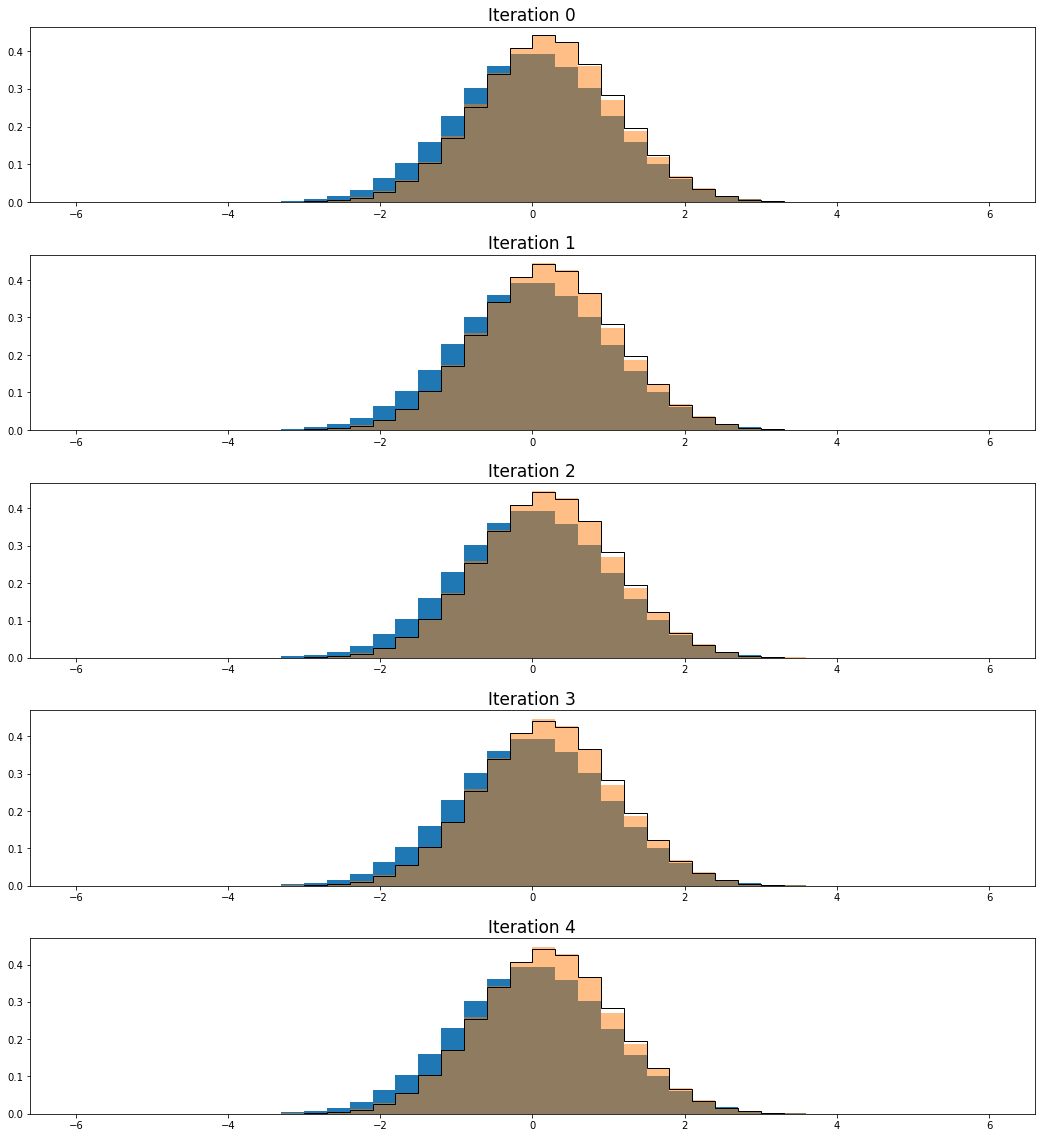

In [61]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [62]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

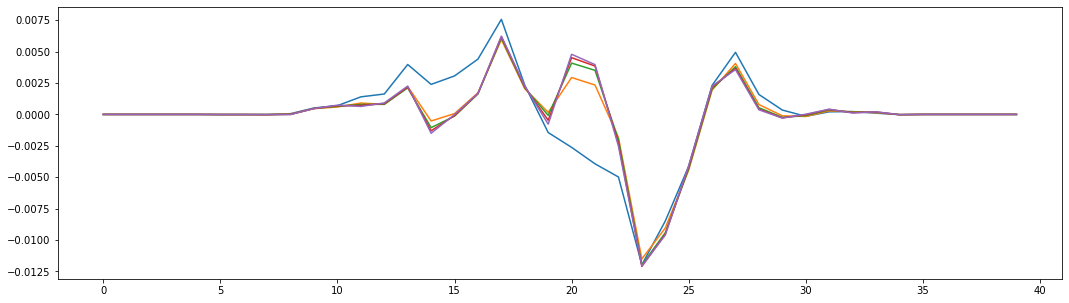

In [63]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

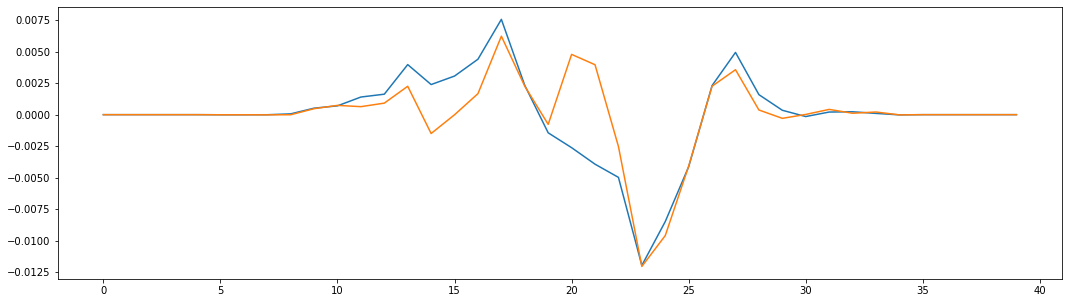

In [64]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

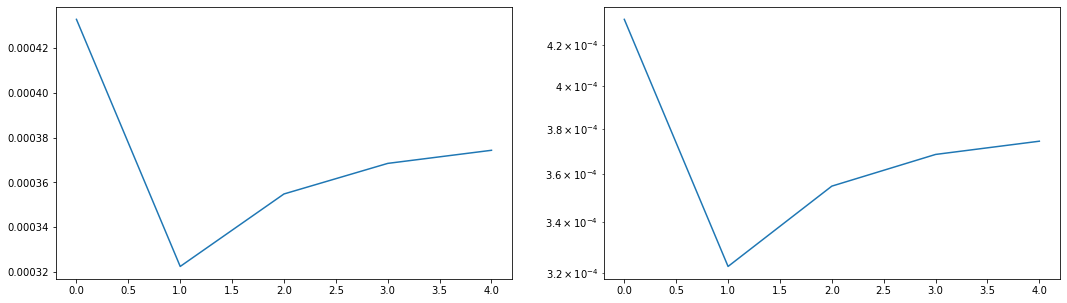

In [65]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

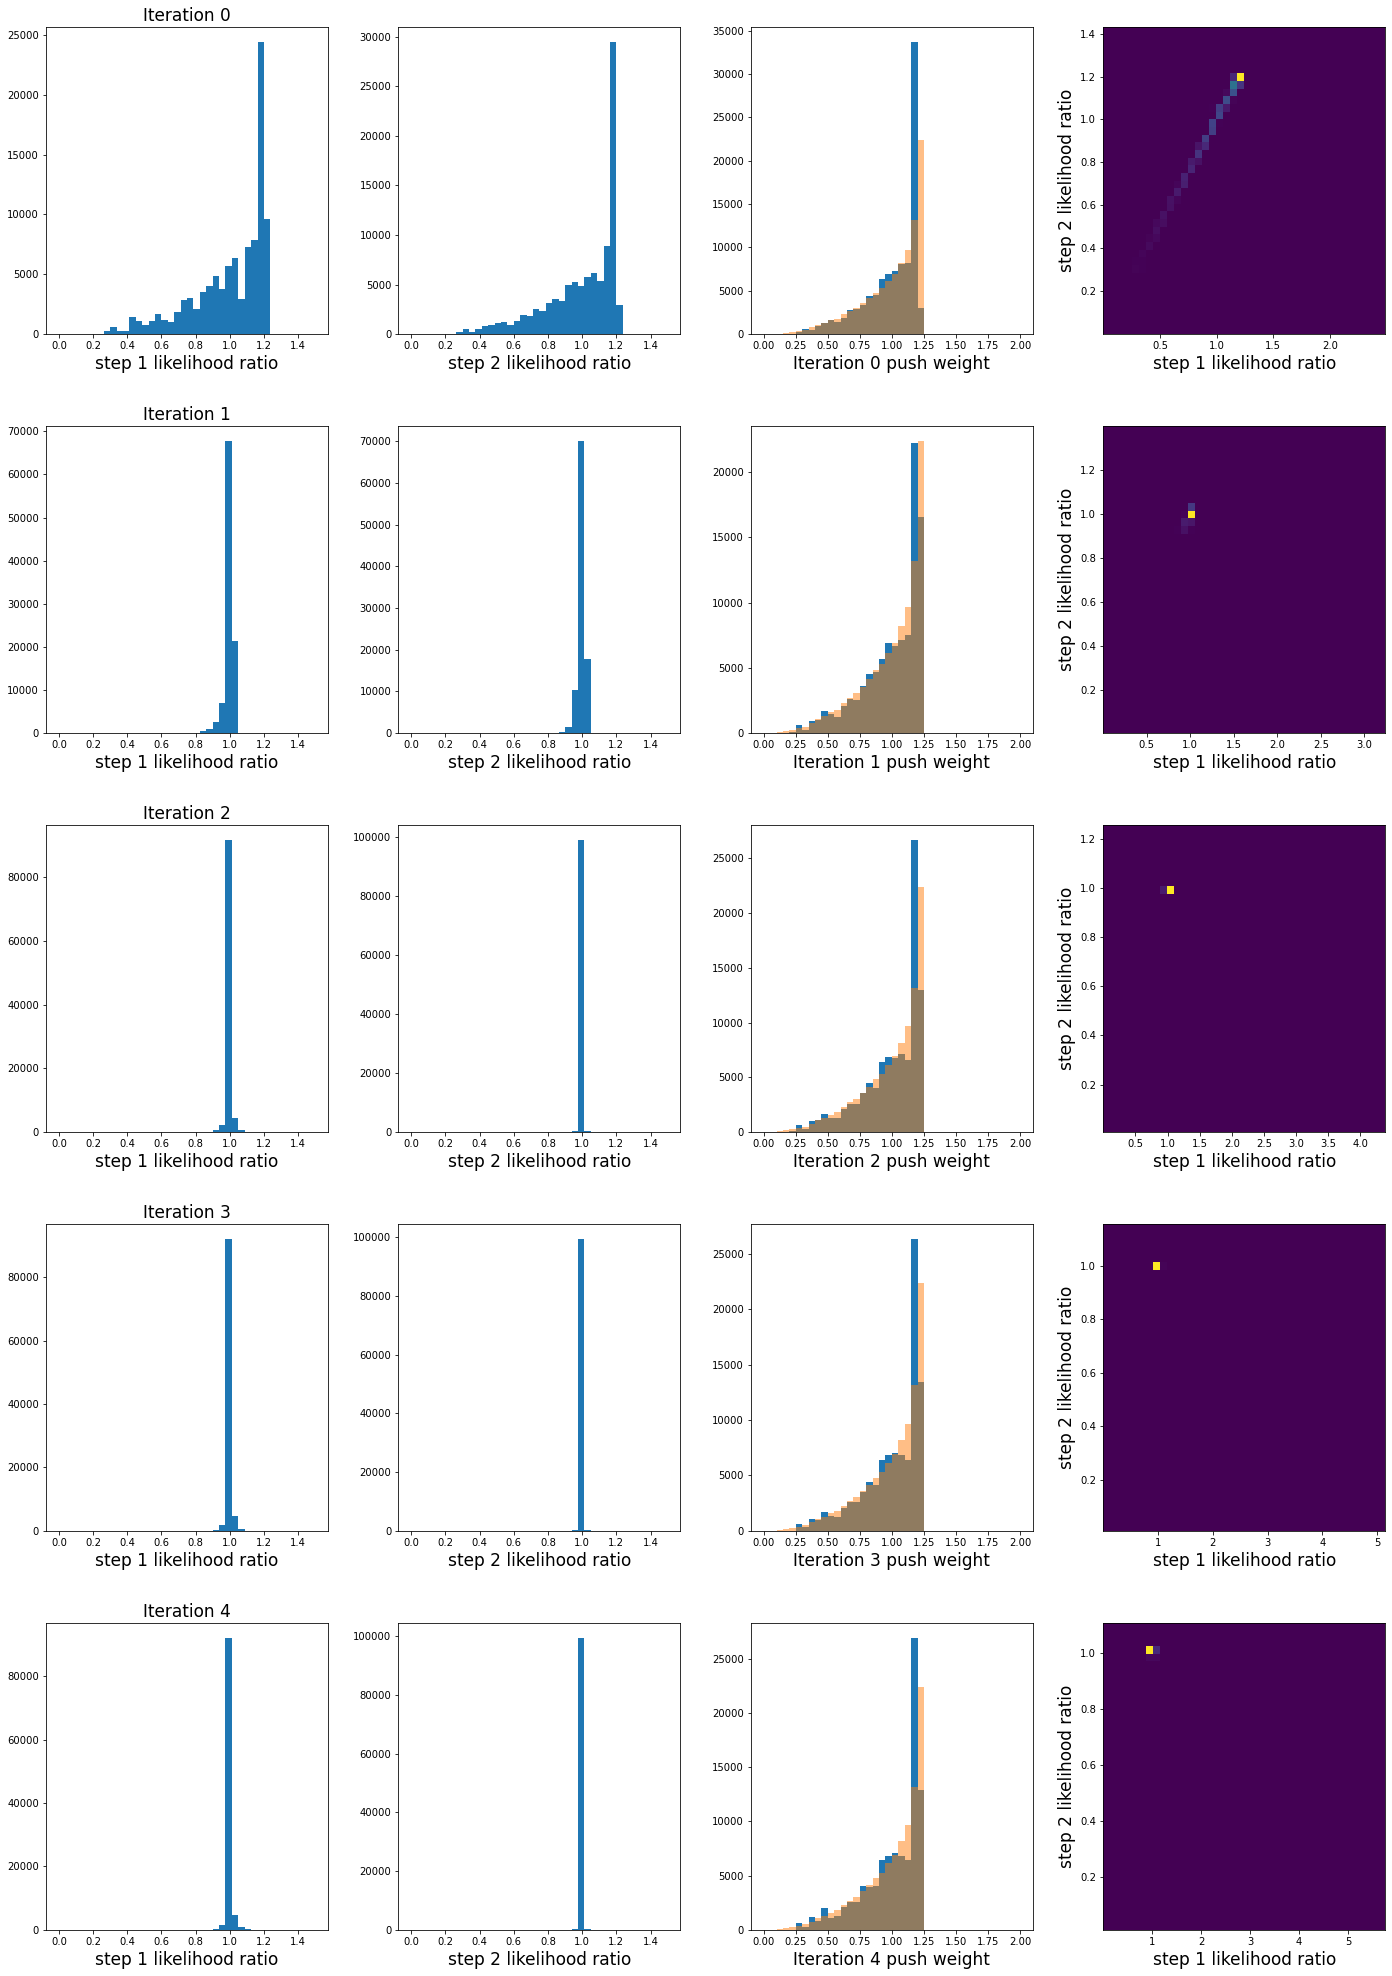

In [66]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

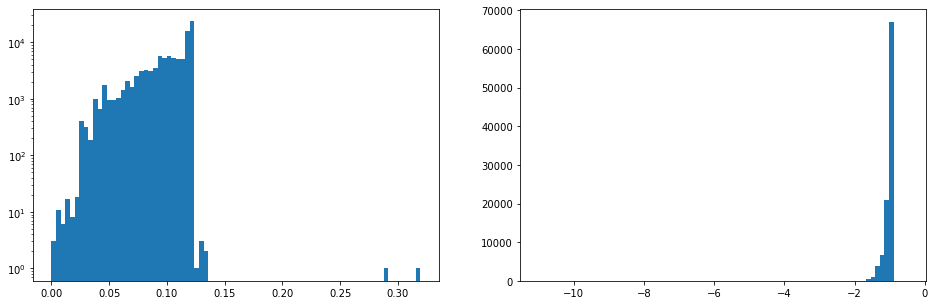

In [67]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

final_push_weights_scaled = np.clip( final_push_weights_scaled, 1e-11, 1e11)

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

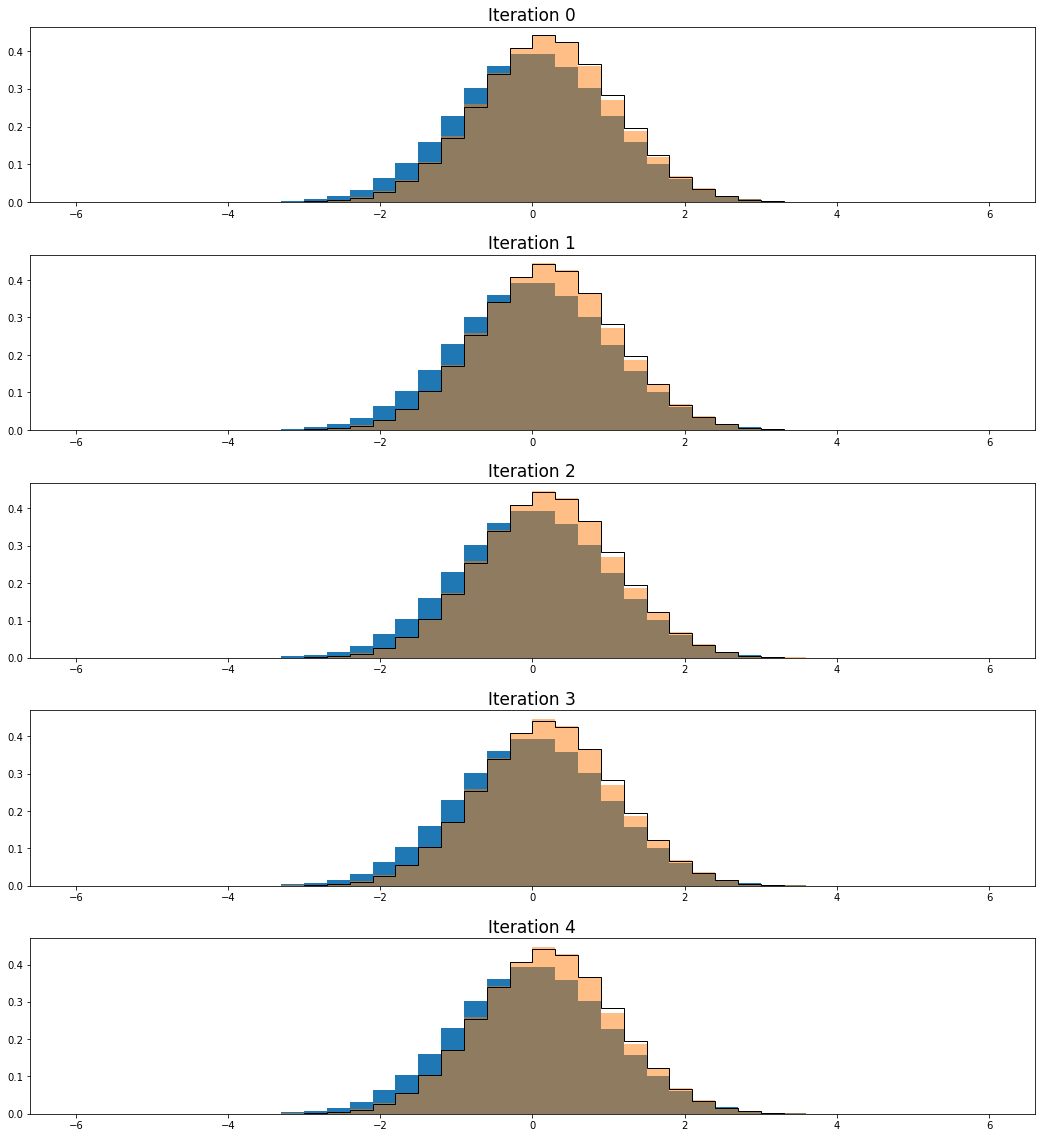

In [68]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [69]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

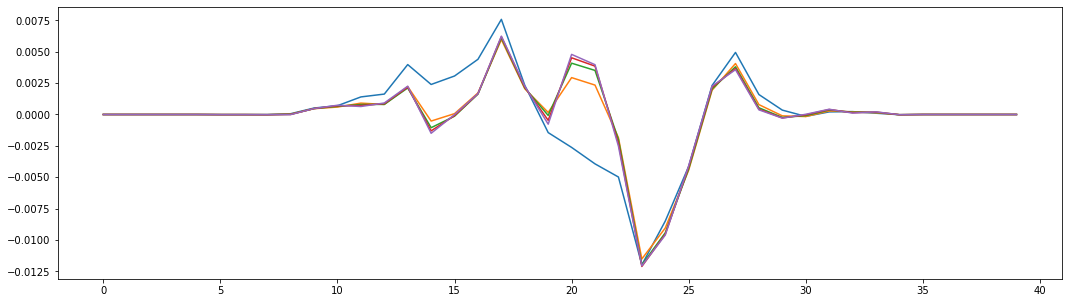

In [70]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

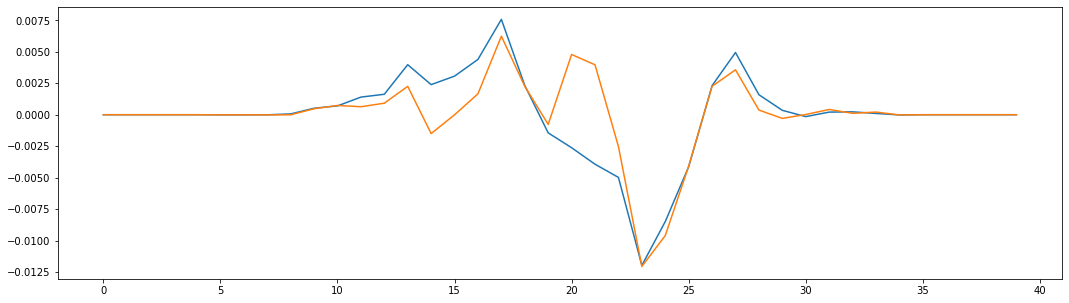

In [71]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

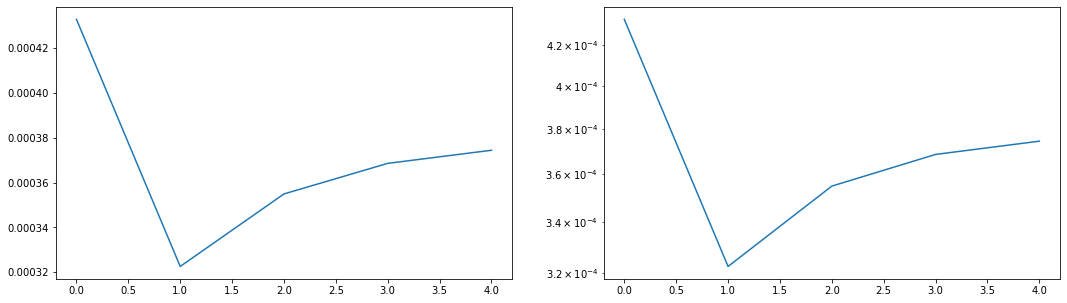

In [72]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [73]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.000  rms 0.219      step 2 mean  1.000  rms 0.213
  iter  1 : step 1 mean  0.997  rms 0.030      step 2 mean  0.997  rms 0.020
  iter  2 : step 1 mean  1.000  rms 0.024      step 2 mean  1.000  rms 0.006
  iter  3 : step 1 mean  1.000  rms 0.025      step 2 mean  1.000  rms 0.005
  iter  4 : step 1 mean  1.000  rms 0.026      step 2 mean  1.000  rms 0.005


<function matplotlib.pyplot.show(close=None, block=None)>

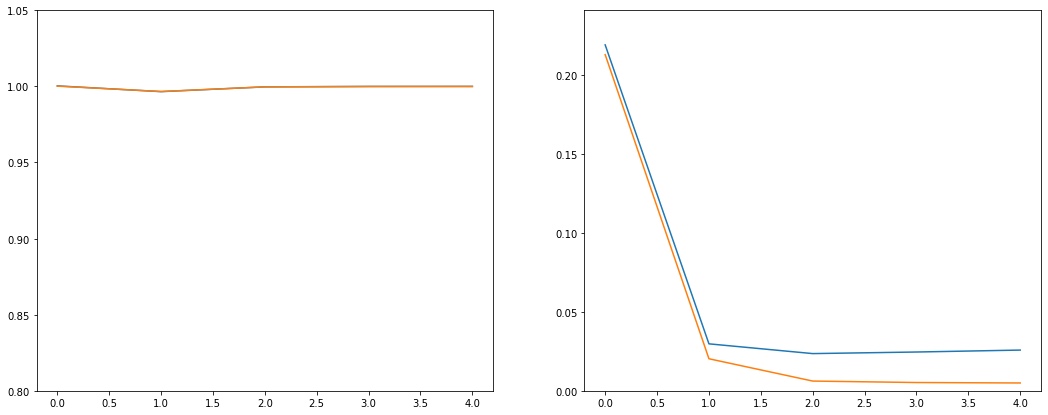

In [74]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

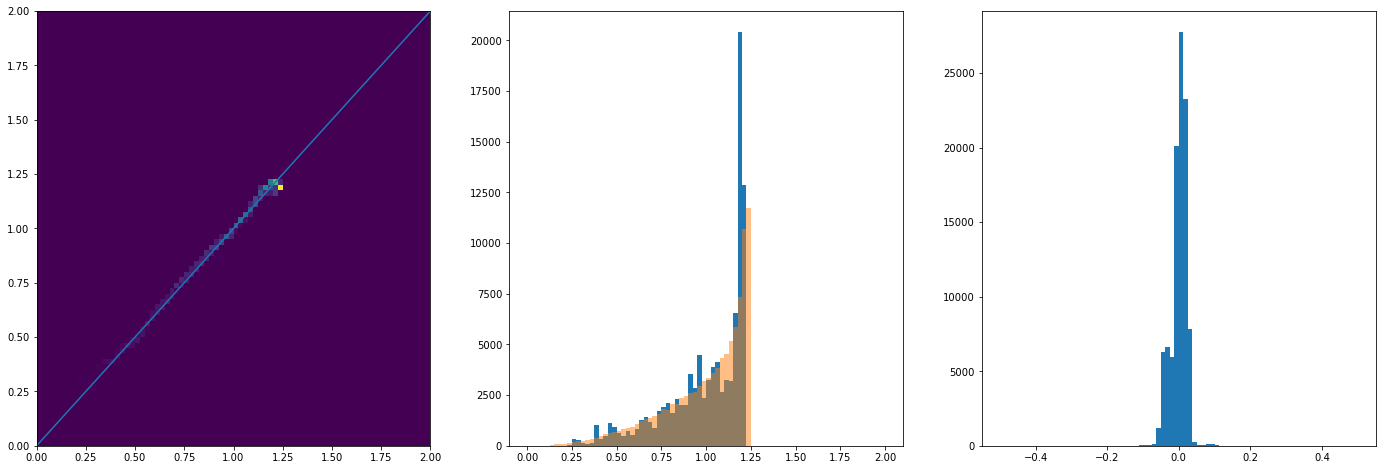

In [75]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [76]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.02424




In [77]:

verbose = False



import gc

In [78]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        #print("\n Creating bootstrap sample %3d" % bi )
        #boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        fname = "%s/bootstrap-points-%03d.npy" % (ds_input_dir, bi)
        print('\n Reading bootstrap sample from file: %s' % fname )
        with open( fname, 'rb' ) as f :
            boot_true_det_pts = np.load(f)
        
    else :
        this_ngen_true = ngen_true
        if use_poisson_fluctuations_around_ngen_true : this_ngen_true = np.random.poisson( ngen_true )
        print("\n Creating toy sample %3d,  this_ngen_true = %d" % (bi, this_ngen_true) )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=this_ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        

        
#    boot_of_return_dict = of.omnifold6b( 
#        train_both, boot_true_det_pts, of_niter, model, verbose, 
#        batch_size_setval, learning_rate_setval, epochs_setval )

#    rd = simple_pdf.simple_pdf2b( train_both, boot_true_det_pts, 
#                             train_train_det_within_sphere, train_train_gen_within_sphere,
#                             of_niter, radius, norm_radius2, False, False )

#    rd = fit_pdf_omnifold1a( train_both, boot_true_det_pts, of_niter, 0 )
    
    rd = hist_pdf_omnifold1a( train_both, boot_true_det_pts, of_niter, 0 )
    
    
    
    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = rd["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )
        
    del boot_final_push_weights_scaled
    del rd
    gc.collect()
    
    


 Creating toy sample   0,  this_ngen_true = 10088
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.72508134 1.02048756 0.89739425 ... 1.20682887 1.11289278 1.03713978]
 weights_push at the beginning
[0.70768353 1.02496447 0.89228697 ... 1.21235026 1.12615022 1.04340628]
 weights_push at the beginning
[0.7045509  1.02520438 0.89107247 ... 1.2187247  1.12910542 1.04422335]
 weights_push at the beginning
[0.70272347 1.02463376 0.8898597  ... 1.22404471 1.13028155 1.04399032]


 bootstrap 0 final push weights scaled:
[0.07073542 0.10330115 0.08964612 ... 0.12385855 0.11409515 0.10527623]

 Creating toy sample   1,  this_ngen_true = 10137
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.74044448 1.02589063 0.90563886 ... 1.15328562 1.09665344 1.04061735]
 weights_push at the beginning
[0.7305862  1.03518929 0.90228785 ... 1.13134683 1.10469739 1.05154466]
 weights_push at the beginning
[0.73212012 1.03908826 0.


 Creating toy sample  13,  this_ngen_true = 10169
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70598612 1.01589221 0.87466716 ... 1.15206779 1.12707632 1.03754861]
 weights_push at the beginning
[0.69407762 1.02073306 0.86685799 ... 1.11752835 1.14520556 1.04649091]
 weights_push at the beginning
[0.69613099 1.02145072 0.86538011 ... 1.10118069 1.15023556 1.04942801]
 weights_push at the beginning
[0.69847821 1.02143368 0.86470193 ... 1.09364925 1.15227006 1.0510872 ]


 bootstrap 13 final push weights scaled:
[0.07122518 0.10387071 0.08789787 ... 0.1108862  0.11726995 0.10702872]

 Creating toy sample  14,  this_ngen_true = 10032
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.73223602 1.04315317 0.91618644 ... 1.2014122  1.11335139 1.05571518]
 weights_push at the beginning
[0.71760351 1.05428664 0.91459356 ... 1.19907552 1.12478608 1.06615353]
 weights_push at the beginning
[0.71746082 1.05797951 0


 Creating toy sample  27,  this_ngen_true = 9945
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.71469474 1.01146327 0.86834631 ... 1.15210536 1.13378396 1.03310841]
 weights_push at the beginning
[0.70378676 1.01543324 0.86010016 ... 1.13636508 1.14953904 1.03987455]
 weights_push at the beginning
[0.70428929 1.01690461 0.85942942 ... 1.1330302  1.15146778 1.04222712]
 weights_push at the beginning
[0.70427992 1.01806875 0.85968846 ... 1.13142975 1.15086566 1.04389189]


 bootstrap 27 final push weights scaled:
[0.06998488 0.10137027 0.08554912 ... 0.1123337  0.11433954 0.10397633]

 Creating toy sample  28,  this_ngen_true = 9835
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70773773 1.04426828 0.91921106 ... 1.15777122 1.12810817 1.0618977 ]
 weights_push at the beginning
[0.68762512 1.05187237 0.91955247 ... 1.1457769  1.1440935  1.07289814]
 weights_push at the beginning
[0.68370384 1.05230203 0.9

 weights_push at the beginning
[0.73604246 1.01163513 0.90648953 ... 1.06859339 1.10472036 1.02682865]
 weights_push at the beginning
[0.72169207 1.01271677 0.90647785 ... 1.03767093 1.11173977 1.02895423]
 weights_push at the beginning
[0.71996461 1.01161843 0.9084685  ... 1.03176812 1.11071552 1.02825078]
 weights_push at the beginning
[0.71927586 1.01038362 0.909488   ... 1.03173472 1.10921053 1.02751972]


 bootstrap 40 final push weights scaled:
[0.07207824 0.10119508 0.09123706 ... 0.10350314 0.11108664 0.10297372]

 Creating toy sample  41,  this_ngen_true = 9973
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.71173768 1.02471434 0.8928766  ... 1.18293206 1.13159601 1.04423439]
 weights_push at the beginning
[0.69877973 1.0299527  0.88790642 ... 1.17767412 1.14976366 1.05234543]
 weights_push at the beginning
[0.69878804 1.0310825  0.88706036 ... 1.17992268 1.15503527 1.05466111]
 weights_push at the beginning
[0.69898297 1.03172432 0.886

 weights_push at the beginning
[0.71606379 1.05074622 0.8874237  ... 1.09933816 1.13361573 1.07292313]


 bootstrap 53 final push weights scaled:
[0.07000909 0.10269569 0.08644797 ... 0.10782617 0.11057587 0.10495917]

 Creating toy sample  54,  this_ngen_true = 9811
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.72811278 1.03162387 0.90179424 ... 1.14028637 1.12379208 1.0503919 ]
 weights_push at the beginning
[0.71106364 1.038532   0.89776108 ... 1.12639572 1.13777661 1.06067681]
 weights_push at the beginning
[0.70797169 1.03985229 0.89784074 ... 1.11934915 1.13958519 1.06399075]
 weights_push at the beginning
[0.7059833  1.04013763 0.89813917 ... 1.11344074 1.13936198 1.06600019]


 bootstrap 54 final push weights scaled:
[0.0690877  0.10206286 0.08814983 ... 0.10866275 0.11171958 0.10475867]

 Creating toy sample  55,  this_ngen_true = 10123
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.72453642 1



 bootstrap 67 final push weights scaled:
[0.06635697 0.10447712 0.08741475 ... 0.10900097 0.1139999  0.1063348 ]

 Creating toy sample  68,  this_ngen_true = 9738
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70826367 1.03468954 0.87474583 ... 1.18233335 1.15023541 1.05673328]
 weights_push at the beginning
[0.69481208 1.04335766 0.86304527 ... 1.18282995 1.17351617 1.06875152]
 weights_push at the beginning
[0.69601859 1.0455413  0.85880344 ... 1.18318094 1.1801665  1.07207912]
 weights_push at the beginning
[0.69760268 1.04641573 0.85596591 ... 1.18144336 1.183279   1.07352631]


 bootstrap 68 final push weights scaled:
[0.06804151 0.10195837 0.08313797 ... 0.11476062 0.11542519 0.10463108]

 Creating toy sample  69,  this_ngen_true = 9938
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70585255 1.01779675 0.89780855 ... 1.23990194 1.11131531 1.03440892]
 weights_push at the beginning
[0.68702566 1.


 Creating toy sample  81,  this_ngen_true = 10144
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.7082429  1.02108026 0.88305268 ... 1.13255986 1.1136895  1.03861158]
 weights_push at the beginning
[0.69290743 1.02737329 0.87520877 ... 1.10242476 1.12250983 1.04665868]
 weights_push at the beginning
[0.69187138 1.02859652 0.87193918 ... 1.0909525  1.12160962 1.04869329]
 weights_push at the beginning
[0.69169549 1.02838899 0.86890044 ... 1.08601445 1.1196317  1.04930415]


 bootstrap 81 final push weights scaled:
[0.07014373 0.10425316 0.08785194 ... 0.1098808  0.11338392 0.10646518]

 Creating toy sample  82,  this_ngen_true = 9972
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.72098145 1.00201952 0.8937421  ... 1.12154822 1.10211947 1.019395  ]
 weights_push at the beginning
[0.70401777 1.00361124 0.89284436 ... 1.09569395 1.10985147 1.0231474 ]
 weights_push at the beginning
[0.69972069 1.00452044 0.


 Creating toy sample  95,  this_ngen_true = 9996
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.72564032 1.00391539 0.90445303 ... 1.18863386 1.09833245 1.02015739]
 weights_push at the beginning
[0.70648719 1.00106805 0.9021724  ... 1.18025384 1.10962142 1.01994875]
 weights_push at the beginning
[0.70219147 0.99636329 0.9017353  ... 1.1782852  1.11243722 1.01690124]
 weights_push at the beginning
[0.6997341  0.99197009 0.90040663 ... 1.17909065 1.11367229 1.01394474]


 bootstrap 95 final push weights scaled:
[0.0697583  0.09877626 0.08983041 ... 0.11799935 0.11138629 0.1011023 ]

 Creating toy sample  96,  this_ngen_true = 10053
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.71686531 1.01664818 0.88982299 ... 1.10806097 1.1031036  1.03059008]
 weights_push at the beginning
[0.70134597 1.02253214 0.88595021 ... 1.07534326 1.11092299 1.03571648]
 weights_push at the beginning
[0.70042651 1.02388569 0.

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.71534256 1.02147438 0.87245792 ... 1.17261175 1.12569703 1.04114295]
 weights_push at the beginning
[0.70937251 1.02940792 0.86140032 ... 1.15857281 1.13916741 1.05119335]
 weights_push at the beginning
[0.71435178 1.03292781 0.85723239 ... 1.1572275  1.14062255 1.05516358]
 weights_push at the beginning
[0.71802293 1.03524622 0.85448839 ... 1.15910453 1.14000328 1.05756007]


 bootstrap 108 final push weights scaled:
[0.07036479 0.10130492 0.08328101 ... 0.11343564 0.11125191 0.10347798]

 Creating toy sample 109,  this_ngen_true = 10091
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.71032944 1.02788217 0.88374219 ... 1.13714212 1.1047456  1.04205252]
 weights_push at the beginning
[0.69457304 1.04001131 0.87697711 ... 1.11576907 1.11123663 1.05337462]
 weights_push at the beginning
[0.69296273 1.04550172 0.87533382 ... 1.11563695 1.11013283 1.05742448]
 w

 weights_push at the beginning
[0.69697979 1.02691442 0.90699151 ... 1.17015625 1.12107333 1.04307327]
 weights_push at the beginning
[0.67302253 1.03213274 0.90947834 ... 1.15336063 1.13761576 1.04966122]
 weights_push at the beginning
[0.66538541 1.03231743 0.91395474 ... 1.14994903 1.14395404 1.05023016]
 weights_push at the beginning
[0.66002745 1.03166723 0.91757021 ... 1.15195779 1.14842016 1.04980388]


 bootstrap 122 final push weights scaled:
[0.06539386 0.10285061 0.09183637 ... 0.11528885 0.11493372 0.10467351]

 Creating toy sample 123,  this_ngen_true = 9937
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.72709109 1.04094796 0.90933968 ... 1.14502731 1.11956475 1.05756867]
 weights_push at the beginning
[0.71239257 1.05032014 0.90423341 ... 1.13070707 1.1316686  1.06928544]
 weights_push at the beginning
[0.71170092 1.05268717 0.90203911 ... 1.12556939 1.13291873 1.07286323]
 weights_push at the beginning
[0.7118591  1.053455   0.90


 Creating toy sample 136,  this_ngen_true = 9936
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70275078 0.996607   0.87770427 ... 1.1645091  1.11166999 1.01556147]
 weights_push at the beginning
[0.68757926 0.99621814 0.87462364 ... 1.13915241 1.12559044 1.01752328]
 weights_push at the beginning
[0.68573303 0.99487591 0.87610729 ... 1.13177788 1.12985032 1.01728359]
 weights_push at the beginning
[0.68447621 0.99366988 0.87726917 ... 1.13019589 1.13240171 1.01698146]


 bootstrap 136 final push weights scaled:
[0.06788595 0.09864152 0.08725701 ... 0.11228121 0.11271459 0.10103995]

 Creating toy sample 137,  this_ngen_true = 10042
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.7373884  1.03118937 0.90566529 ... 1.13001735 1.1229406  1.04857689]
 weights_push at the beginning
[0.72738873 1.03710419 0.90223488 ... 1.1165429  1.13536366 1.05684383]
 weights_push at the beginning
[0.72874746 1.03816765 0


 Creating toy sample 150,  this_ngen_true = 9862
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69771802 1.02425766 0.89932877 ... 1.13710844 1.11427956 1.03900615]
 weights_push at the beginning
[0.67813143 1.02913576 0.8995655  ... 1.11639524 1.12142181 1.04369484]
 weights_push at the beginning
[0.67518514 1.02929366 0.9018764  ... 1.10971425 1.11948998 1.04318245]
 weights_push at the beginning
[0.67436109 1.02863475 0.90317129 ... 1.10643748 1.11709892 1.04213606]


 bootstrap 150 final push weights scaled:
[0.0664887  0.10137652 0.08914064 ... 0.10885491 0.10997594 0.1026937 ]

 Creating toy sample 151,  this_ngen_true = 9948
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70430393 1.00841654 0.88726786 ... 1.18215796 1.10689851 1.02469608]
 weights_push at the beginning
[0.6862053  1.01265795 0.88709907 ... 1.16645048 1.11468986 1.02945763]
 weights_push at the beginning
[0.68211265 1.01459673 0.


 Creating toy sample 164,  this_ngen_true = 10039
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69880627 1.02146494 0.86819214 ... 1.22714846 1.10026918 1.03670399]
 weights_push at the beginning
[0.68868127 1.03463313 0.85696    ... 1.22969828 1.1061255  1.04944278]
 weights_push at the beginning
[0.69349241 1.04171928 0.85163636 ... 1.24053363 1.1043756  1.05529019]
 weights_push at the beginning
[0.69841447 1.0463717  0.84731671 ... 1.25303692 1.10231459 1.05874366]


 bootstrap 164 final push weights scaled:
[0.07051285 0.10539223 0.08470589 ... 0.12690949 0.11049936 0.1065213 ]

 Creating toy sample 165,  this_ngen_true = 10036
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70633256 1.01096498 0.8855637  ... 1.13346521 1.12065657 1.02882685]
 weights_push at the beginning
[0.68962985 1.01238217 0.88251167 ... 1.11724276 1.13330403 1.03167169]
 weights_push at the beginning
[0.68716909 1.01096565 

 weights_push at the beginning
[0.67510095 1.00613715 0.90648136 ... 1.08783882 1.11595495 1.02205841]
 weights_push at the beginning
[0.67092954 1.00416326 0.90833185 ... 1.08277712 1.11778901 1.02021111]


 bootstrap 177 final push weights scaled:
[0.0671415  0.1008398  0.09147737 ... 0.10864553 0.11259245 0.10246634]

 Creating toy sample 178,  this_ngen_true = 9937
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.74283628 1.00581258 0.92807511 ... 1.14189091 1.09953816 1.02024855]
 weights_push at the beginning
[0.72711545 1.00129338 0.93314577 ... 1.11955166 1.10889871 1.01755499]
 weights_push at the beginning
[0.72380732 0.99684474 0.9373222  ... 1.10750071 1.11029589 1.01420777]
 weights_push at the beginning
[0.72192451 0.99381867 0.93962355 ... 1.09944364 1.11045789 1.0121895 ]


 bootstrap 178 final push weights scaled:
[0.07161117 0.09856737 0.09350633 ... 0.1086274  0.11032552 0.10048728]

 Creating toy sample 179,  this_ngen_true = 

 weights_push at the beginning
[0.68681948 1.02224125 0.9010552  ... 1.10431819 1.13091313 1.0421433 ]
 weights_push at the beginning
[0.68215527 1.02052002 0.90228911 ... 1.09957904 1.13260821 1.04110918]


 bootstrap 191 final push weights scaled:
[0.06851861 0.10293381 0.09124296 ... 0.11086447 0.11452215 0.10507011]

 Creating toy sample 192,  this_ngen_true = 10012
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.7098572  1.03263986 0.89520464 ... 1.12162555 1.10948304 1.04698461]
 weights_push at the beginning
[0.69087259 1.04281442 0.8902093  ... 1.09090705 1.11934956 1.05713834]
 weights_push at the beginning
[0.688201   1.04561042 0.88885024 ... 1.08006711 1.12006059 1.05918556]
 weights_push at the beginning
[0.68734545 1.04623279 0.88760317 ... 1.07684273 1.11975167 1.05910616]


 bootstrap 192 final push weights scaled:
[0.06876633 0.10473888 0.08875445 ... 0.10774703 0.11207548 0.10596456]

 Creating toy sample 193,  this_ngen_true =


 Creating toy sample 205,  this_ngen_true = 9946
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.72767733 1.03580929 0.89204376 ... 1.17174843 1.11318296 1.05242422]
 weights_push at the beginning
[0.71493311 1.04901696 0.88411172 ... 1.16542994 1.12495215 1.06727463]
 weights_push at the beginning
[0.71605269 1.05487665 0.88138942 ... 1.16552122 1.1260763  1.07354393]
 weights_push at the beginning
[0.71755664 1.05849696 0.87968565 ... 1.1672034  1.1256705  1.07734933]


 bootstrap 205 final push weights scaled:
[0.07146396 0.10554782 0.08738803 ... 0.11623066 0.11190032 0.10743259]

 Creating toy sample 206,  this_ngen_true = 10057
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.71620744 1.03273395 0.88784285 ... 1.09373936 1.12066377 1.05015793]
 weights_push at the beginning
[0.70166689 1.04241936 0.88107161 ... 1.06331146 1.12993437 1.06132137]
 weights_push at the beginning
[0.70123623 1.04555862 0


 Creating toy sample 219,  this_ngen_true = 9817
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.72352137 0.99955344 0.89715118 ... 1.20006169 1.08871969 1.01603364]
 weights_push at the beginning
[0.7089544  0.999402   0.89629972 ... 1.18387943 1.09583799 1.01869295]
 weights_push at the beginning
[0.70768374 0.9978454  0.89811769 ... 1.17954455 1.09658273 1.01919662]
 weights_push at the beginning
[0.70746883 0.99624603 0.89929337 ... 1.18094514 1.09658091 1.0195724 ]


 bootstrap 219 final push weights scaled:
[0.0694538  0.09766845 0.08836922 ... 0.11624641 0.1076388  0.10014673]

 Creating toy sample 220,  this_ngen_true = 10016
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.68659271 1.02248636 0.85818382 ... 1.20109258 1.12003339 1.04249097]
 weights_push at the beginning
[0.670346   1.03202531 0.84821794 ... 1.19178014 1.12943167 1.05416111]
 weights_push at the beginning
[0.67013731 1.03456828 0


 Creating toy sample 232,  this_ngen_true = 10054
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70244257 1.0420188  0.89946266 ... 1.13963459 1.12121448 1.05625307]
 weights_push at the beginning
[0.68409022 1.0526182  0.8952461  ... 1.12439167 1.13168387 1.06631412]
 weights_push at the beginning
[0.68249114 1.05501874 0.8940729  ... 1.12143291 1.1318943  1.06753025]
 weights_push at the beginning
[0.68263274 1.05527712 0.89286028 ... 1.12144387 1.13120544 1.06677079]


 bootstrap 232 final push weights scaled:
[0.06866829 0.10605636 0.08964982 ... 0.11277392 0.11368289 0.10712712]

 Creating toy sample 233,  this_ngen_true = 10050
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.71642414 1.02017284 0.88656676 ... 1.13227571 1.11058937 1.03541309]
 weights_push at the beginning
[0.70235118 1.0270899  0.88097844 ... 1.1105725  1.11879686 1.04214714]
 weights_push at the beginning
[0.70245863 1.02940715 

 weights_push at the beginning
[0.7302677  1.04790157 0.92715913 ... 1.14541471 1.12392033 1.06317001]
 weights_push at the beginning
[0.71323946 1.05666014 0.92591322 ... 1.14381343 1.13646316 1.0737754 ]
 weights_push at the beginning
[0.7106727  1.05870382 0.92546402 ... 1.1468416  1.13817973 1.07671448]
 weights_push at the beginning
[0.70952014 1.05965942 0.92457607 ... 1.14944476 1.13836943 1.07839498]


 bootstrap 246 final push weights scaled:
[0.07089853 0.10611195 0.09241955 ... 0.11516682 0.11389709 0.10804997]

 Creating toy sample 247,  this_ngen_true = 9971
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.72911018 0.99991112 0.87696307 ... 1.14030814 1.10304837 1.01715804]
 weights_push at the beginning
[0.71695738 1.00263262 0.87210675 ... 1.1284807  1.11118416 1.02098659]
 weights_push at the beginning
[0.71590994 1.00374635 0.87340891 ... 1.13405723 1.11093046 1.0221419 ]
 weights_push at the beginning
[0.71476795 1.00428149 0.87

 weights_push at the beginning
[0.71515255 1.00887238 0.88573653 ... 1.20982448 1.12012867 1.0298694 ]


 bootstrap 260 final push weights scaled:
[0.07148377 0.10097918 0.08873496 ... 0.12149914 0.11209507 0.10314788]

 Creating toy sample 261,  this_ngen_true = 10019
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.74997879 1.00782619 0.90733761 ... 1.15440773 1.10480732 1.02364183]
 weights_push at the beginning
[0.73802177 1.00781882 0.90536288 ... 1.14553375 1.1168175  1.0254128 ]
 weights_push at the beginning
[0.7364673  1.00660164 0.90613856 ... 1.14839789 1.12013419 1.02490392]
 weights_push at the beginning
[0.73525672 1.00561628 0.90643312 ... 1.15351078 1.12199028 1.02441925]


 bootstrap 261 final push weights scaled:
[0.07355494 0.10068967 0.09081768 ... 0.11603154 0.11255386 0.10261286]

 Creating toy sample 262,  this_ngen_true = 10144
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.7088394

 weights_push at the beginning
[0.72712499 1.0406516  0.89065596 ... 1.01724145 1.15313565 1.06518039]
 weights_push at the beginning
[0.72516979 1.04285784 0.88869854 ... 1.00582879 1.15814181 1.06948263]
 weights_push at the beginning
[0.72351241 1.04407009 0.88768177 ... 1.00199323 1.16010127 1.07216544]


 bootstrap 274 final push weights scaled:
[0.07128666 0.10323829 0.08763021 ... 0.0988615  0.11468052 0.10612483]

 Creating toy sample 275,  this_ngen_true = 10021
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70468553 1.01936717 0.88883997 ... 1.12453322 1.10835537 1.03325911]
 weights_push at the beginning
[0.69167707 1.02647597 0.88504897 ... 1.08518467 1.1169567  1.03912732]
 weights_push at the beginning
[0.69336355 1.02907258 0.88460658 ... 1.06903418 1.11710154 1.03978591]
 weights_push at the beginning
[0.69588783 1.03042466 0.88388816 ... 1.06145353 1.11639442 1.03929227]


 bootstrap 275 final push weights scaled:
[0.0699692  0


 Creating toy sample 288,  this_ngen_true = 9827
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70782798 1.01985664 0.87398283 ... 1.13366287 1.14196642 1.04195451]
 weights_push at the beginning
[0.69303745 1.02437677 0.86686082 ... 1.11528216 1.16059453 1.04970205]
 weights_push at the beginning
[0.69185538 1.02529934 0.86711531 ... 1.10797194 1.16404149 1.0518341 ]
 weights_push at the beginning
[0.69111557 1.02592929 0.86829287 ... 1.1022576  1.16464502 1.05325734]


 bootstrap 288 final push weights scaled:
[0.06783195 0.10089644 0.08546185 ... 0.10777991 0.11443875 0.10364697]

 Creating toy sample 289,  this_ngen_true = 9992
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.7291042  1.00890615 0.90383556 ... 1.21635011 1.11332648 1.02397246]
 weights_push at the beginning
[0.71248204 1.00781757 0.90463187 ... 1.23392475 1.12699704 1.0230659 ]
 weights_push at the beginning
[0.7098147  1.00512466 0.

 weights_push at the beginning
[0.68626615 1.01529729 0.89608529 ... 1.14447357 1.10923792 1.02969938]
 weights_push at the beginning
[0.66270943 1.01990875 0.89877296 ... 1.12850158 1.11635558 1.03357696]
 weights_push at the beginning
[0.65665126 1.02137623 0.90317154 ... 1.12870381 1.11564287 1.0338311 ]
 weights_push at the beginning
[0.65330229 1.02244074 0.90608878 ... 1.13127198 1.11479002 1.03390475]


 bootstrap 301 final push weights scaled:
[0.06446469 0.10135964 0.08992635 ... 0.11215736 0.11034914 0.1024117 ]

 Creating toy sample 302,  this_ngen_true = 9991
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.72095081 1.02627132 0.88996241 ... 1.10718354 1.12934845 1.04557859]
 weights_push at the beginning
[0.70510984 1.03171405 0.88348511 ... 1.09817362 1.14350513 1.05374331]
 weights_push at the beginning
[0.70247263 1.03221026 0.88205339 ... 1.10511233 1.14538145 1.05554334]
 weights_push at the beginning
[0.70041232 1.0317275  0.88


 Creating toy sample 315,  this_ngen_true = 10028
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69436177 1.01690986 0.88097838 ... 1.23628013 1.11226768 1.03303945]
 weights_push at the beginning
[0.67062259 1.02298431 0.8777021  ... 1.24489167 1.12423444 1.03933171]
 weights_push at the beginning
[0.66492365 1.02407646 0.879534   ... 1.25155068 1.12560311 1.03964221]
 weights_push at the beginning
[0.66191973 1.02407512 0.88119646 ... 1.2572838  1.12553069 1.0389026 ]


 bootstrap 315 final push weights scaled:
[0.06617403 0.10268301 0.08849633 ... 0.12656617 0.11284971 0.10410762]

 Creating toy sample 316,  this_ngen_true = 10016
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.74356548 0.99785879 0.88442187 ... 1.16019245 1.08429104 1.01231705]
 weights_push at the beginning
[0.73617764 1.00316386 0.87787164 ... 1.12882987 1.09212844 1.01803873]
 weights_push at the beginning
[0.73933627 1.00699413 

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.68342457 1.03131382 0.90250285 ... 1.21316991 1.10911676 1.04608684]
 weights_push at the beginning
[0.6625814  1.03925599 0.90077478 ... 1.20226081 1.11636247 1.05475134]
 weights_push at the beginning
[0.65902334 1.04137563 0.90012771 ... 1.19685155 1.1158551  1.05714025]
 weights_push at the beginning
[0.65748471 1.04217507 0.8986329  ... 1.19387335 1.11487314 1.05832369]


 bootstrap 329 final push weights scaled:
[0.0649145  0.10313051 0.0887147  ... 0.11784697 0.11019946 0.104773  ]

 Creating toy sample 330,  this_ngen_true = 9928
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69831194 1.01831256 0.87372296 ... 1.15986292 1.12853475 1.03862039]
 weights_push at the beginning
[0.68190606 1.02324002 0.86724614 ... 1.14901948 1.14373496 1.04615395]
 weights_push at the beginning
[0.68099373 1.02328395 0.8670926  ... 1.15010551 1.14629145 1.04725519]
 we

 weights_push at the beginning
[0.64975408 1.04668579 0.8962634  ... 1.11297303 1.12081561 1.065507  ]
 weights_push at the beginning
[0.64660854 1.04633701 0.89740808 ... 1.11426481 1.12161223 1.06634923]


 bootstrap 343 final push weights scaled:
[0.0653286  0.10596916 0.09107219 ... 0.11329742 0.11379535 0.10812217]

 Creating toy sample 344,  this_ngen_true = 10059
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.71373792 1.0064725  0.89248079 ... 1.17920333 1.09291714 1.02111442]
 weights_push at the beginning
[0.69445419 1.01123581 0.89068493 ... 1.17148227 1.10140044 1.02652865]
 weights_push at the beginning
[0.69022545 1.0130929  0.89180955 ... 1.17706973 1.1035594  1.0283975 ]
 weights_push at the beginning
[0.68766328 1.01404813 0.8923021  ... 1.18536736 1.10536405 1.02937485]


 bootstrap 344 final push weights scaled:
[0.06895928 0.10207031 0.08978267 ... 0.1199439  0.11138452 0.10361331]

 Creating toy sample 345,  this_ngen_true =

 weights_push at the beginning
[0.69948482 1.06276768 0.90339357 ... 1.10727615 1.13700908 1.08381257]


 bootstrap 356 final push weights scaled:
[0.06983064 0.10600896 0.08991923 ... 0.11034203 0.11327863 0.108191  ]

 Creating toy sample 357,  this_ngen_true = 9846
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.75194923 1.03256586 0.91226354 ... 1.11502398 1.11262991 1.04936225]
 weights_push at the beginning
[0.74537196 1.04038161 0.90863227 ... 1.08851784 1.12534742 1.0601283 ]
 weights_push at the beginning
[0.74941002 1.04270532 0.90834678 ... 1.07932531 1.12794877 1.06417472]
 weights_push at the beginning
[0.75290964 1.04378745 0.90863022 ... 1.07710096 1.12873616 1.06664727]


 bootstrap 357 final push weights scaled:
[0.07439184 0.10284458 0.08953717 ... 0.10609847 0.11116102 0.10521456]

 Creating toy sample 358,  this_ngen_true = 9999
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.72479576 


 Creating toy sample 371,  this_ngen_true = 10065
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.73237343 1.02185779 0.90604396 ... 1.20898403 1.09729097 1.03614561]
 weights_push at the beginning
[0.72055152 1.02831412 0.90403489 ... 1.22330087 1.10237001 1.04359911]
 weights_push at the beginning
[0.72214895 1.03053325 0.90435625 ... 1.24096446 1.10039495 1.04631195]
 weights_push at the beginning
[0.72458933 1.03168466 0.90423113 ... 1.25750414 1.0981951  1.04809058]


 bootstrap 371 final push weights scaled:
[0.07316773 0.10392242 0.09098514 ... 0.12799513 0.11035423 0.10564785]

 Creating toy sample 372,  this_ngen_true = 10031
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.71976214 1.03908197 0.90873473 ... 1.16929622 1.11909491 1.0548153 ]
 weights_push at the beginning
[0.70667882 1.04757118 0.90563923 ... 1.16996649 1.12860023 1.06465328]
 weights_push at the beginning
[0.70827784 1.04944476 

 weights_push at the beginning
[0.68059878 1.01653259 0.87893444 ... 1.17213639 1.13126897 1.03261743]
 weights_push at the beginning
[0.68134353 1.01674392 0.87853043 ... 1.17411642 1.13034753 1.03198689]


 bootstrap 384 final push weights scaled:
[0.06927562 0.10327382 0.08912674 ... 0.11926799 0.11467363 0.10474629]

 Creating toy sample 385,  this_ngen_true = 9977
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.72975161 1.03182268 0.89971073 ... 1.11082053 1.11846643 1.05085674]
 weights_push at the beginning
[0.71532346 1.03975872 0.89318568 ... 1.0906525  1.13119558 1.06279318]
 weights_push at the beginning
[0.71434202 1.04179355 0.8907445  ... 1.0873429  1.1331042  1.0674731 ]
 weights_push at the beginning
[0.71414699 1.04245926 0.88881508 ... 1.08818737 1.13336408 1.07042589]


 bootstrap 385 final push weights scaled:
[0.07122677 0.10403613 0.08852029 ... 0.10869225 0.113067   0.1070327 ]

 Creating toy sample 386,  this_ngen_true = 

 weights_push at the beginning
[0.71973606 1.02420664 0.8963665  ... 1.14042793 1.16290296 1.05264565]


 bootstrap 397 final push weights scaled:
[0.07157112 0.1017562  0.08930724 ... 0.11407704 0.11595762 0.1047369 ]

 Creating toy sample 398,  this_ngen_true = 9937
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.7436416  1.02973696 0.90695733 ... 1.10733932 1.11913251 1.04500286]
 weights_push at the beginning
[0.73290202 1.03778939 0.90445315 ... 1.07780943 1.13764502 1.05385168]
 weights_push at the beginning
[0.73396493 1.04023649 0.90572302 ... 1.06911561 1.14514854 1.05579093]
 weights_push at the beginning
[0.73518312 1.04132264 0.90733844 ... 1.06851821 1.15027811 1.05603809]


 bootstrap 398 final push weights scaled:
[0.07314212 0.10355185 0.0903433  ... 0.10640394 0.11472122 0.10491443]

 Creating toy sample 399,  this_ngen_true = 9971
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70296497 


 Creating toy sample 412,  this_ngen_true = 9873
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.71465272 1.02218899 0.89983003 ... 1.16708823 1.11478791 1.03567515]
 weights_push at the beginning
[0.69499474 1.02666228 0.89768523 ... 1.16549378 1.12547826 1.03876943]
 weights_push at the beginning
[0.69083312 1.02689477 0.89854246 ... 1.16930643 1.12621194 1.03682943]
 weights_push at the beginning
[0.68851746 1.0264605  0.89885387 ... 1.17209334 1.12587061 1.0343226 ]


 bootstrap 412 final push weights scaled:
[0.06780314 0.10129873 0.08873911 ... 0.11580841 0.1111253  0.10188365]

 Creating toy sample 413,  this_ngen_true = 10017
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.6900313  1.02470718 0.89572106 ... 1.12071474 1.12507478 1.04152176]
 weights_push at the beginning
[0.66861684 1.02940146 0.8970582  ... 1.10323731 1.13781744 1.04715183]
 weights_push at the beginning
[0.66512903 1.02898593 0


 Creating toy sample 425,  this_ngen_true = 10149
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69543132 1.03821169 0.90215665 ... 1.19507694 1.1281337  1.05657439]
 weights_push at the beginning
[0.67547544 1.04411635 0.8990015  ... 1.19092291 1.14087676 1.06555728]
 weights_push at the beginning
[0.67298093 1.04317897 0.89851624 ... 1.18899657 1.14216775 1.06671213]
 weights_push at the beginning
[0.67275658 1.0410042  0.89762739 ... 1.18760647 1.14185497 1.06656736]


 bootstrap 425 final push weights scaled:
[0.06831909 0.10542265 0.09098336 ... 0.1203971  0.11583342 0.10822412]

 Creating toy sample 426,  this_ngen_true = 9879
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.67678408 1.04576784 0.89332584 ... 1.18961703 1.149952   1.06493574]
 weights_push at the beginning
[0.65386451 1.05414225 0.89047466 ... 1.19287066 1.16974917 1.07502157]
 weights_push at the beginning
[0.64904244 1.05449983 0


 Creating toy sample 439,  this_ngen_true = 10066
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.75061296 1.01072599 0.87164951 ... 1.22058983 1.12360742 1.032803  ]
 weights_push at the beginning
[0.74307652 1.01528187 0.85834966 ... 1.23319522 1.14419167 1.04200353]
 weights_push at the beginning
[0.74465573 1.01661042 0.85401951 ... 1.24457263 1.15121727 1.04570813]
 weights_push at the beginning
[0.74507636 1.01706974 0.85170621 ... 1.2537341  1.15491366 1.04782569]


 bootstrap 439 final push weights scaled:
[0.07495293 0.10239682 0.08559132 ... 0.1269029  0.11649989 0.10562373]

 Creating toy sample 440,  this_ngen_true = 10001
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.72687968 1.0283063  0.87589523 ... 1.19449577 1.13013148 1.05062959]
 weights_push at the beginning
[0.718872   1.03691614 0.86277253 ... 1.18296888 1.14776169 1.0642561 ]
 weights_push at the beginning
[0.72233023 1.03948307 

 weights_push at the beginning
[0.70036128 1.03841243 0.95161768 ... 1.07334885 1.09373529 1.04962149]


 bootstrap 452 final push weights scaled:
[0.06951263 0.1031367  0.09465089 ... 0.106359   0.1084845  0.10431104]

 Creating toy sample 453,  this_ngen_true = 10176
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.7102124  1.05465216 0.90751019 ... 1.16907597 1.13123322 1.06907331]
 weights_push at the beginning
[0.69035645 1.06746224 0.90247775 ... 1.15776805 1.14521267 1.08135403]
 weights_push at the beginning
[0.6875641  1.0707667  0.90090541 ... 1.14898551 1.14627794 1.08297981]
 weights_push at the beginning
[0.68676665 1.0718098  0.89965288 ... 1.14251456 1.14513766 1.08220374]


 bootstrap 453 final push weights scaled:
[0.06984141 0.10911274 0.0914367  ... 0.11578091 0.11636468 0.10998443]

 Creating toy sample 454,  this_ngen_true = 9940
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70583635

 weights_push at the beginning
[0.71187509 1.01498395 0.88076923 ... 1.04138137 1.1409292  1.03863671]


 bootstrap 465 final push weights scaled:
[0.0711863  0.1013489  0.08799747 ... 0.10369132 0.11410452 0.1037883 ]

 Creating toy sample 466,  this_ngen_true = 10127
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.72207194 1.01677284 0.88486416 ... 1.20087124 1.09842521 1.03132732]
 weights_push at the beginning
[0.71029595 1.02502494 0.87876239 ... 1.19302722 1.10519491 1.03950955]
 weights_push at the beginning
[0.71110893 1.02856208 0.87763107 ... 1.19554803 1.10456039 1.04228927]
 weights_push at the beginning
[0.71203007 1.03031776 0.87696094 ... 1.20125451 1.10341131 1.04339643]


 bootstrap 466 final push weights scaled:
[0.07215448 0.10443905 0.08877294 ... 0.12222557 0.11165351 0.10571133]

 Creating toy sample 467,  this_ngen_true = 9902
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.76451781


 Creating toy sample 480,  this_ngen_true = 10018
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.71398416 1.02602266 0.89819205 ... 1.15357803 1.10962055 1.04130585]
 weights_push at the beginning
[0.70169124 1.03364343 0.89425877 ... 1.13629495 1.11705329 1.0497213 ]
 weights_push at the beginning
[0.70298628 1.03645036 0.89288711 ... 1.13210237 1.11655774 1.0527386 ]
 weights_push at the beginning
[0.704872   1.03796836 0.89120055 ... 1.13041759 1.11573108 1.05459001]


 bootstrap 480 final push weights scaled:
[0.07077863 0.1040908  0.08911251 ... 0.11302398 0.11173318 0.10580014]

 Creating toy sample 481,  this_ngen_true = 9840
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.71995902 1.03394377 0.90059332 ... 1.09174443 1.14289251 1.05189516]
 weights_push at the beginning
[0.70582277 1.03982494 0.89664705 ... 1.078428   1.16030677 1.05878571]
 weights_push at the beginning
[0.70480204 1.04129468 0


 Creating toy sample 494,  this_ngen_true = 9731
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.72255858 1.0423731  0.91894351 ... 1.1175965  1.12442918 1.05747014]
 weights_push at the beginning
[0.70236969 1.05078869 0.91800033 ... 1.10200092 1.14176069 1.06710165]
 weights_push at the beginning
[0.69764805 1.05206631 0.91879225 ... 1.10142324 1.14796348 1.06846824]
 weights_push at the beginning
[0.69478815 1.05194407 0.91932828 ... 1.10561158 1.15209713 1.06813713]


 bootstrap 494 final push weights scaled:
[0.06738097 0.10233226 0.08950905 ... 0.10809485 0.11243985 0.10386945]

 Creating toy sample 495,  this_ngen_true = 9975
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.6938353  1.0146389  0.86815558 ... 1.17872089 1.11888031 1.03544851]
 weights_push at the beginning
[0.6774662  1.0208946  0.85960033 ... 1.16106065 1.130522   1.045038  ]
 weights_push at the beginning
[0.67642463 1.02269848 0.

In [79]:
print('\n\n Done\n\n')



 Done


